# UnconBacktest Example: TS Momentum in Cryptocurrencies

We will run a simple "uncon backtest" to test whether 4 of the larger coins (BTC, ETH, ADA, BNB) show time-series momentum. In other words, if they have done well recently, do they tend to continue to do well?

1. Run the first cell to compute returns for these coins since 2016.

In [40]:
# compute returns 
import yfinance as yf 
import numpy as np

data = yf.download(['ADA-USD','BNB-USD','BTC-USD','ETH-USD'],'2020-1-1', auto_adjust=False)
ret = data['Adj Close'] / data['Adj Close'].shift() - 1

[*********************100%***********************]  4 of 4 completed


In [41]:
ret

Ticker,ADA-USD,BNB-USD,BTC-USD,ETH-USD
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,-0.021131,-0.048365,-0.029819,-0.025931
2020-01-03,0.043632,0.048625,0.051452,0.053069
2020-01-04,0.012142,0.016915,0.008955,0.006690
2020-01-05,0.003642,0.015802,0.000089,0.008939
...,...,...,...,...
2025-07-31,-0.030623,-0.011950,-0.017593,-0.029277
2025-08-01,-0.032961,-0.033790,-0.021062,-0.056359
2025-08-02,-0.025147,-0.027127,-0.006999,-0.027412


<Axes: title={'center': 'Cumulative Returns of Major Cryptocurrencies'}, xlabel='Date'>

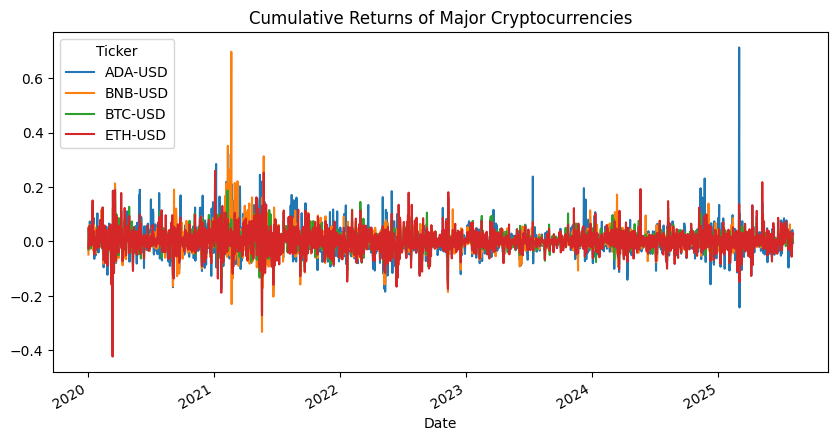

In [42]:
ret.plot(figsize=(10,5), title='Cumulative Returns of Major Cryptocurrencies')

2. The signal on each day for each coin will be: sqrt(10)*(avg past 10 day ret - avg past 365 day ret) / (stdev past 365 day ret). You can think of this as the z-score of the past 10 day returns, and it tells us if a coin is doing better than it usually does. Technical note: we multiply by sqrt(10) here because the stdev is calculated on daily data but we want to "z-score" the average 10 day returns.

<Axes: title={'center': 'New Signal for Major Cryptocurrencies'}, xlabel='Date'>

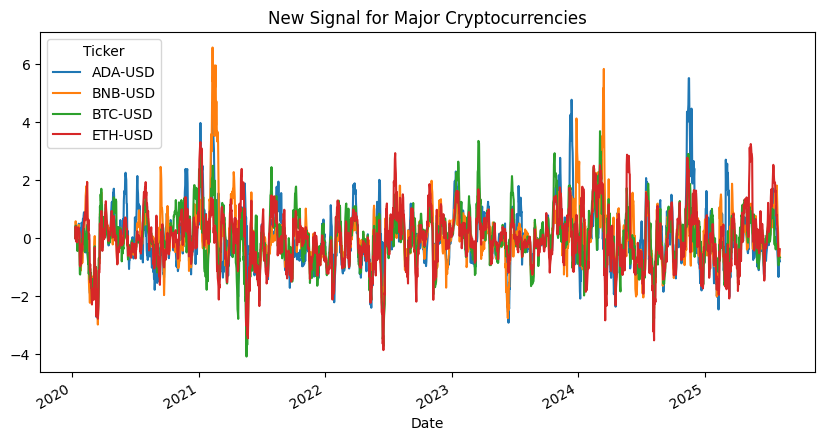

In [43]:
z_score_rets = np.sqrt(10) * (ret.rolling(10,min_periods=1).mean() - ret.rolling(365,min_periods=10).mean()) / ret.rolling(365,min_periods=10).std()
z_score_rets.plot(figsize=(10,5), title='New Signal for Major Cryptocurrencies')

3. The signal from (2) will have extreme values. Pass them through a tanh function to curtail these. These are your final daily portfolio weights.

<Axes: title={'center': 'Tanh Signal for Major Cryptocurrencies'}, xlabel='Date'>

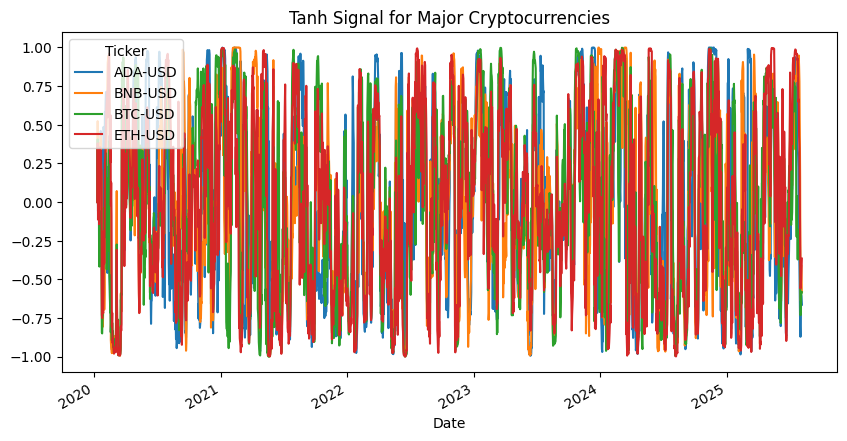

In [44]:
new_signal = np.tanh(z_score_rets) # weights of each coin on each day
#new_signal = new_signal/ new_signal.abs().sum(axis=1).values[:, None] # normalize to sum to 1
new_signal.plot(figsize=(10,5), title='Tanh Signal for Major Cryptocurrencies')

In [45]:
new_signal

Ticker,ADA-USD,BNB-USD,BTC-USD,ETH-USD
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-07-31,-0.800714,0.164567,-0.389147,-0.214747
2025-08-01,-0.871329,-0.503431,-0.731897,-0.558607
2025-08-02,-0.752427,-0.637341,-0.724408,-0.541223


4. Compute the returns to the weights from (3). 

In [46]:
new_rets = new_signal.shift() * ret
new_rets

Ticker,ADA-USD,BNB-USD,BTC-USD,ETH-USD
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-07-31,0.019431,-0.005184,0.003038,-0.000690
2025-08-01,0.026392,-0.005561,0.008196,0.012103
2025-08-02,0.021911,0.013657,0.005123,0.015313


<Axes: title={'center': 'New Portfolio Returns'}, xlabel='Date'>

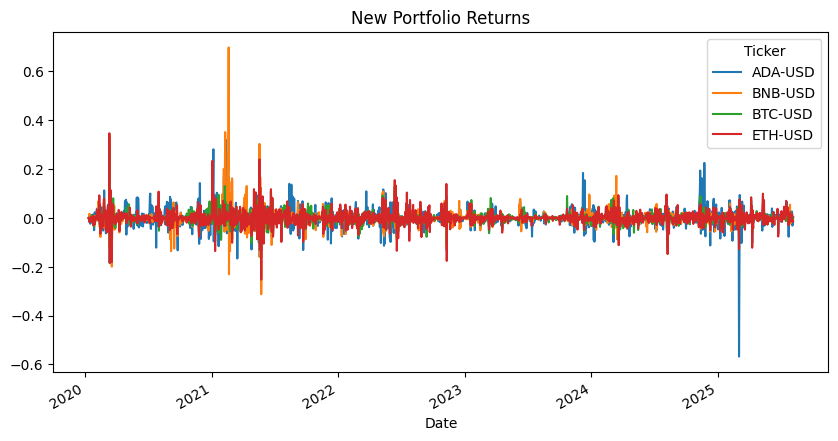

In [47]:
new_rets.plot(figsize=(10,5), title='New Portfolio Returns')

5. What is the Sharpe of these strategies? Plot their cumulative returns.

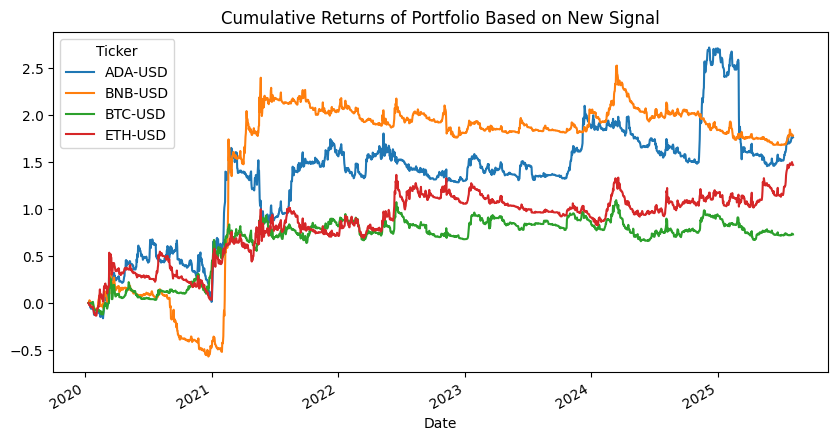

In [48]:
new_rets.cumsum().plot(figsize=(10,5), title='Cumulative Returns of Portfolio Based on New Signal')
sharpe_ratio = new_rets.mean() / new_rets.std() * np.sqrt(365)  # annualized Sharpe ratio

In [49]:
sharpe_ratio

Ticker
ADA-USD    0.441607
BNB-USD    0.489197
BTC-USD    0.323282
ETH-USD    0.484146
dtype: float64

6. How correlated are the timing strategies with the underlying assets?

In [50]:
new_rets.corrwith(ret)

Ticker
ADA-USD   -0.059496
BNB-USD    0.131125
BTC-USD   -0.234833
ETH-USD   -0.232662
dtype: float64